# Detecting pneumonia

Data from Kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

There is another larger x-ray dataset with multiple diseases from NIH: https://www.kaggle.com/datasets/nih-chest-xrays/data

Notes:
- No Normal images in RGB format. Could be linked to pneumonia detection?
- RGB images seem to be smaller in height and width.
- Pneumonia images have "bacteria" or "virus" in the filename. Created label for better classification.
- Normal images seem to have 580 origional images. Data Augmentation?

Origional File arrangement:

In [1]:
"""
[pneumonia_detection]
|
|-pneumonia detection notebook
|
|-[data]
    |
    |- [train] [val] [test]
          |
          |-[NORMAL] - image files
          |
          |-[PNEUMONIA] - image files
"""

'\n[pneumonia_detection]\n|\n|-pneumonia detection notebook\n|\n|-[data]\n    |\n    |- [train] [val] [test]\n          |\n          |-[NORMAL] - image files\n          |\n          |-[PNEUMONIA] - image files\n'

In [2]:
#Imports
import numpy as np
import pandas as pd
import os
import shutil
import glob
import itertools
import random
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from PIL import Image

In [3]:
#Preferences
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

### Data preparation

In [4]:
#Path variables
train_path = "data/train/"
val_path = "data/val/"
test_path = "data/test/"

In [5]:
path_list = [train_path, val_path, test_path]

In [6]:
for path in path_list:
    viral_pneumonia_dir = os.path.join(path, "viral_pneumonia")
    bacterial_pneumonia_dir = os.path.join(path, "bacterial_pneumonia")
    if os.path.exists(viral_pneumonia_dir) and os.path.exists(bacterial_pneumonia_dir):
        pass
    else:
        os.mkdir(viral_pneumonia_dir)
        os.mkdir(bacterial_pneumonia_dir)
        pneumonia_dir = os.path.join(path, "PNEUMONIA")
        for file_name in os.listdir(pneumonia_dir):
            if file_name.endswith(".jpeg"):
                file_path = os.path.join(pneumonia_dir, file_name)
                img = Image.open(file_path)
                if (file_name.find("virus") == (-1)) and (file_name.find("bacteria") == (-1)):
                    pass
                elif file_name.find("virus") != (-1):
                    destination_folder = viral_pneumonia_dir
                elif file_name.find("bacteria") != (-1):
                    destination_folder = bacterial_pneumonia_dir

                shutil.copy(file_path, destination_folder)
                img.close()

#### Checking image size: (Might not need a lot of this)

In [7]:
image_dir_list = ["data/train/NORMAL/", "data/train/PNEUMONIA/"]

In [8]:
image_files = []
image_sizes = []
image_info = []
norm_files = []
norm_info = []
p_files = []
p_info = []
status = ""

In [9]:
for image_dir in image_dir_list:
    for file in os.listdir(image_dir):
        if file.endswith(".jpeg"):
            image_files.append(f"{image_dir + file}")

In [10]:
for file in os.listdir(image_dir_list[0]):
    if file.endswith(".jpeg"):
        norm_files.append(f"{image_dir_list[0] + file}")

In [11]:
for file in os.listdir(image_dir_list[1]):
    if file.endswith(".jpeg"):
        p_files.append(f"{image_dir_list[1] + file}")

In [12]:
for image_file in image_files:
    img = Image.open(image_file)
    if (image_file.find("virus") == (-1)) and (image_file.find("bacteria") == (-1)):
        status = "normal"
    elif image_file.find("virus") != (-1):
        status = "virus"
    elif image_file.find("bacteria") != (-1):
        status = "bacteria"
    image_sizes.append(img.size)
    temp_dict = {"file":image_file,
                 "height": img.size[0],
                 "width": img.size[1],
                 "mode": img.mode,
                 "issue": status}
    image_info.append(temp_dict)
    img.close()

In [13]:
for image_file in norm_files:
    img = Image.open(image_file)
    if (image_file.find("virus") == (-1)) and (image_file.find("bacteria") == (-1)):
        status = "normal"
    else:
        status = "unknown"
    image_sizes.append(img.size)
    temp_dict = {"file":image_file,
                 "height": img.size[0],
                 "width": img.size[1],
                 "mode": img.mode,
                 "status": status}
    norm_info.append(temp_dict)
    img.close()

In [14]:
for image_file in p_files:
    img = Image.open(image_file)
    if image_file.find("virus") != (-1):
        status = "virus"
    elif image_file.find("bacteria") != (-1):
        status = "bacteria"
    image_sizes.append(img.size)
    temp_dict = {"file":image_file,
                 "height": img.size[0],
                 "width": img.size[1],
                 "mode": img.mode,
                 "issue": status}
    p_info.append(temp_dict)
    img.close()

In [15]:
df = pd.DataFrame(image_info)

In [16]:
norm_df = pd.DataFrame(norm_info)

In [17]:
p_df = pd.DataFrame(p_info)

In [18]:
p_df.head()

,file,height,width,mode,issue
0,data/train/PNEUMONIA/person1213_virus_2058.jpeg,1208,656,L,virus
1,data/train/PNEUMONIA/person1180_virus_2011.jpeg,936,592,L,virus
2,data/train/PNEUMONIA/person764_bacteria_2668.jpeg,1016,736,L,bacteria
3,data/train/PNEUMONIA/person558_bacteria_2328.jpeg,1280,905,L,bacteria
4,data/train/PNEUMONIA/person837_virus_1475.jpeg,1656,1320,L,virus


In [19]:
norm_df["stripped_filename"] = norm_df["file"].str.replace("-0002","").str.replace("-0001", "")

In [20]:
norm_df["stripped_filename"] = norm_df["stripped_filename"].str[18:]

In [21]:
norm_df["stripped_filename"] = norm_df["stripped_filename"].str.replace("^NORMAL2","").str.replace("^NORMAL","")

In [22]:
norm_df["stripped_filename"] = norm_df["stripped_filename"].str.replace("^-","")

In [23]:
norm_df.head()

,file,height,width,mode,status,stripped_filename
0,data/train/NORMAL/NORMAL2-IM-0388-0001.jpeg,1388,1009,L,normal,IM-0388.jpeg
1,data/train/NORMAL/NORMAL2-IM-1110-0001.jpeg,1902,1665,L,normal,IM-1110.jpeg
2,data/train/NORMAL/NORMAL2-IM-1039-0001.jpeg,1384,1090,L,normal,IM-1039.jpeg
3,data/train/NORMAL/IM-0371-0001.jpeg,2024,2036,L,normal,IM-0371.jpeg
4,data/train/NORMAL/IM-0494-0001.jpeg,1692,1302,L,normal,IM-0494.jpeg


In [24]:
p_df.head()

,file,height,width,mode,issue
0,data/train/PNEUMONIA/person1213_virus_2058.jpeg,1208,656,L,virus
1,data/train/PNEUMONIA/person1180_virus_2011.jpeg,936,592,L,virus
2,data/train/PNEUMONIA/person764_bacteria_2668.jpeg,1016,736,L,bacteria
3,data/train/PNEUMONIA/person558_bacteria_2328.jpeg,1280,905,L,bacteria
4,data/train/PNEUMONIA/person837_virus_1475.jpeg,1656,1320,L,virus


In [25]:
p_df.issue.value_counts()

bacteria    2500
virus       1315
Name: issue, dtype: int64

In [26]:
p_df["split_filename"] = p_df["file"].str[27:-5]

In [27]:
p_df["split_filename"] = p_df["split_filename"].str.split("_")

In [28]:
p_df.split_filename[0][0]

'1213'

In [29]:
peeps_list = []

In [30]:
for i in range(len(p_df["split_filename"])):
    peeps_list.append(p_df["split_filename"][i][0])

In [31]:
print(len(peeps_list))

3815


In [32]:
p_df["person_num"] = pd.Series(peeps_list)

In [33]:
pic_list = []

In [34]:
for i in range(len(p_df["split_filename"])):
    pic_list.append(p_df["split_filename"][i][2])

In [35]:
p_df["pic_num"] = pd.Series(pic_list)

In [36]:
p_df.pic_num.value_counts()

2058    2
2572    2
2241    2
1706    2
2684    2
       ..
670     1
4495    1
1122    1
1339    1
3304    1
Name: pic_num, Length: 3185, dtype: int64

In [37]:
p_df.person_num.value_counts()

23      30
441     18
30      14
1320    14
348     13
        ..
1208     1
1144     1
800      1
1933     1
825      1
Name: person_num, Length: 1606, dtype: int64

In [38]:
p_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3815 entries, 0 to 3814
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file            3815 non-null   object
 1   height          3815 non-null   int64 
 2   width           3815 non-null   int64 
 3   mode            3815 non-null   object
 4   issue           3815 non-null   object
 5   split_filename  3815 non-null   object
 6   person_num      3815 non-null   object
 7   pic_num         3815 non-null   object
dtypes: int64(2), object(6)
memory usage: 238.6+ KB


### Generating Images for the Neural Network:

In [39]:
datagen = ImageDataGenerator(rescale=1./255)

In [40]:
train_generator = datagen.flow_from_directory(directory=train_path, target_size=(256,256), batch_size=32, color_mode="grayscale", classes=["NORMAL", "viral_pneumonia", "bacterial_pneumonia"], save_format="jpeg")

Found 5097 images belonging to 3 classes.


In [41]:
val_generator = datagen.flow_from_directory(directory=val_path, target_size=(256,256), batch_size=32, color_mode="grayscale", classes=["NORMAL", "viral_pneumonia", "bacterial_pneumonia"], save_format="jpeg")

Found 135 images belonging to 3 classes.


In [42]:
test_generator = datagen.flow_from_directory(directory=test_path, target_size=(256,256), batch_size=32, color_mode="grayscale", classes=["NORMAL", "viral_pneumonia", "bacterial_pneumonia"], save_format="jpeg", shuffle=False)

Found 624 images belonging to 3 classes.


In [43]:
img, labels = next(train_generator)

In [44]:
#Plot function
def plotImages(images_arr):
    """
    Plots images in a gird.
    """
    fig, axes, = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    plt.tight_layout()
    plt.show()

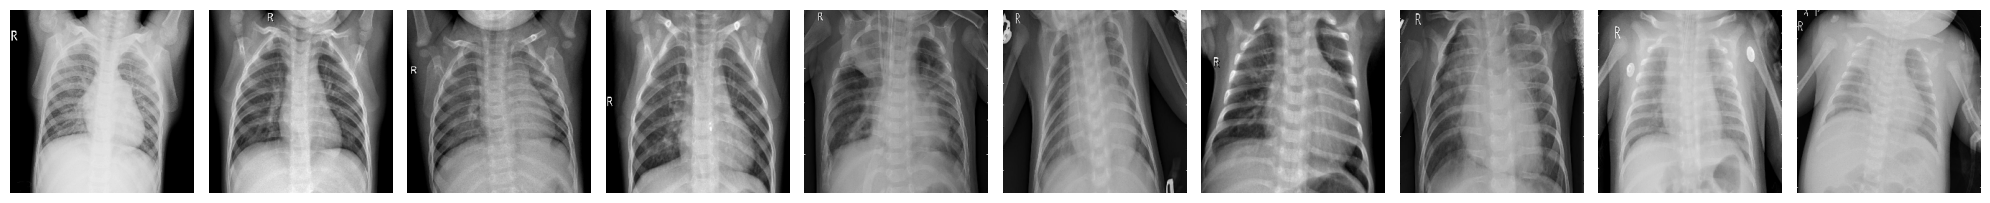

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [45]:
plotImages(img)
print(labels)

In [46]:
#Building a CNN
model = Sequential([
    Conv2D(filters = 64, kernel_size=(3,3), activation="relu", padding="same", input_shape=(256,256,1)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Dropout(0.5),
    Conv2D(filters = 128, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPool2D(pool_size=(2,2), strides=2),
    Dropout(0.5),
    Conv2D(filters = 256, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=3, activation="softmax"),
])

2023-07-27 23:03:11.124457: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 128)       0

In [48]:
#Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])

In [49]:
model.fit(x=train_generator, validation_data=val_generator, epochs=10, verbose=2)

Epoch 1/10
160/160 - 561s - loss: 0.8339 - accuracy: 0.6292 - recall: 0.4944 - val_loss: 0.9032 - val_accuracy: 0.6519 - val_recall: 0.1926 - 561s/epoch - 4s/step
Epoch 2/10
160/160 - 562s - loss: 0.5714 - accuracy: 0.7553 - recall: 0.7183 - val_loss: 0.8443 - val_accuracy: 0.6222 - val_recall: 0.3333 - 562s/epoch - 4s/step
Epoch 3/10
160/160 - 561s - loss: 0.5279 - accuracy: 0.7773 - recall: 0.7502 - val_loss: 0.7491 - val_accuracy: 0.7481 - val_recall: 0.5407 - 561s/epoch - 4s/step
Epoch 4/10
160/160 - 562s - loss: 0.4958 - accuracy: 0.7850 - recall: 0.7644 - val_loss: 0.7300 - val_accuracy: 0.7481 - val_recall: 0.5852 - 562s/epoch - 4s/step
Epoch 5/10
160/160 - 559s - loss: 0.4721 - accuracy: 0.7914 - recall: 0.7710 - val_loss: 0.7354 - val_accuracy: 0.7407 - val_recall: 0.5333 - 559s/epoch - 3s/step
Epoch 6/10
160/160 - 560s - loss: 0.4683 - accuracy: 0.7928 - recall: 0.7746 - val_loss: 0.6691 - val_accuracy: 0.7704 - val_recall: 0.6074 - 560s/epoch - 4s/step
Epoch 7/10
160/160 - 5

### Make a prediction

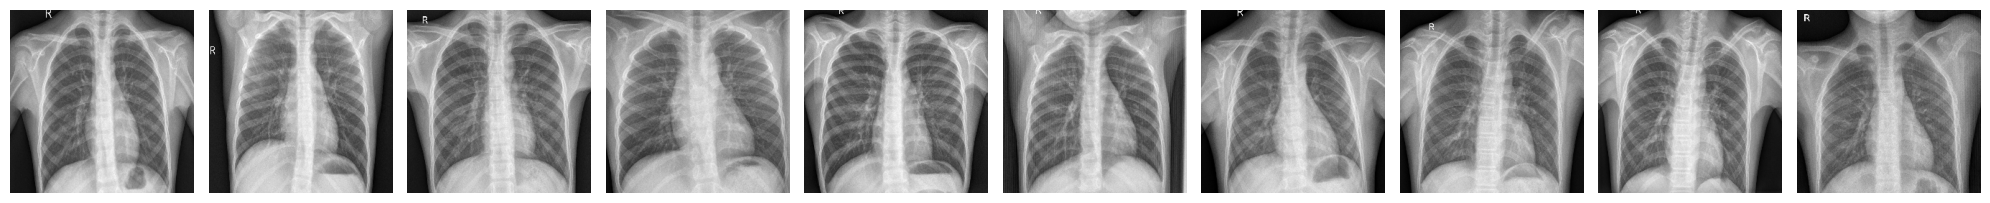

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [50]:
test_imgs, test_labels = next(test_generator)
plotImages(test_imgs)
print(test_labels)

In [51]:
predictions = model.predict(x=test_generator, verbose=0)

In [52]:
cm= confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=-1))

In [53]:
#Confusion matrix plot function from TensorFlows website
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    """
    A function to plot results in a confusion matrix.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment="center", color = "white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Confusion matrix, without normalization
[[ 74  74  86]
 [  1 104  43]
 [  4   9 229]]


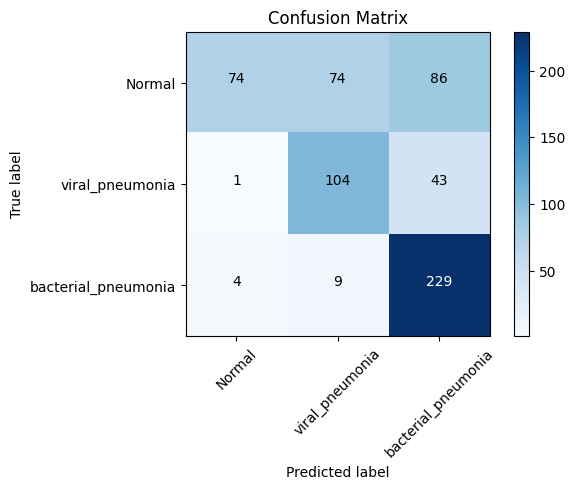

In [54]:
cm_plot_labels = ["Normal","viral_pneumonia", "bacterial_pneumonia"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title = "Confusion Matrix")